In [1]:
# =============================================================================
# DIABETES 30-DAY READMISSION RISK PREDICTOR
# 02 — TARGET ENGINEERING + CLASS IMBALANCE STRATEGY
# Client: Dr. Sarah Chen, Chief Medical Officer, HealthFirst Network
# Consultant: Rabbi Islam Yeasin, IBM Certified Professional Data Scientist
# Date: December 05, 2025
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE  # For later
import sqlite3

# Reproducibility lock-in
SEED = 42
np.random.seed(SEED)
import random
random.seed(SEED)

# Viz standards (hospital palette: blues/greens for trust)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(["#2E86AB", "#A23B72", "#F18F01", "#C73E1D", "#00A676"])
sns.set_context("notebook", font_scale=1.1)

# Reload from our DB
db_path = r"D:\Projects and All\gitupload\upload-folders\diabetes-readmission-predictor\diabetes_hospital.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql("SELECT * FROM patients", conn)
conn.close()

print(f"Data reloaded: {df.shape[0]:,} rows × {df.shape[1]} cols")
df.head()

Data reloaded: 101,766 rows × 50 cols


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [2]:
# =============================================================================
# TARGET VARIABLE: Binary 30-Day Readmission Flag
# =============================================================================

# Engineer Binary Target : 1 = readmitted <30 days, 0 = otherwise
df['readmitted_30d'] = (df['readmitted'] == '<30').astype(int)

#Quick Validation 
print("Target Distribution:")
print(df['readmitted_30d'].value_counts(normalize=True).round(3)*100)
print(f"\n Raw readmitted breakdown:\n{df['readmitted'].value_counts()}")

Target Distribution:
readmitted_30d
0    88.8
1    11.2
Name: proportion, dtype: float64

 Raw readmitted breakdown:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_6184\290338822.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='age_group', y='readmitted_30d', ax=axes[1], ci=None)


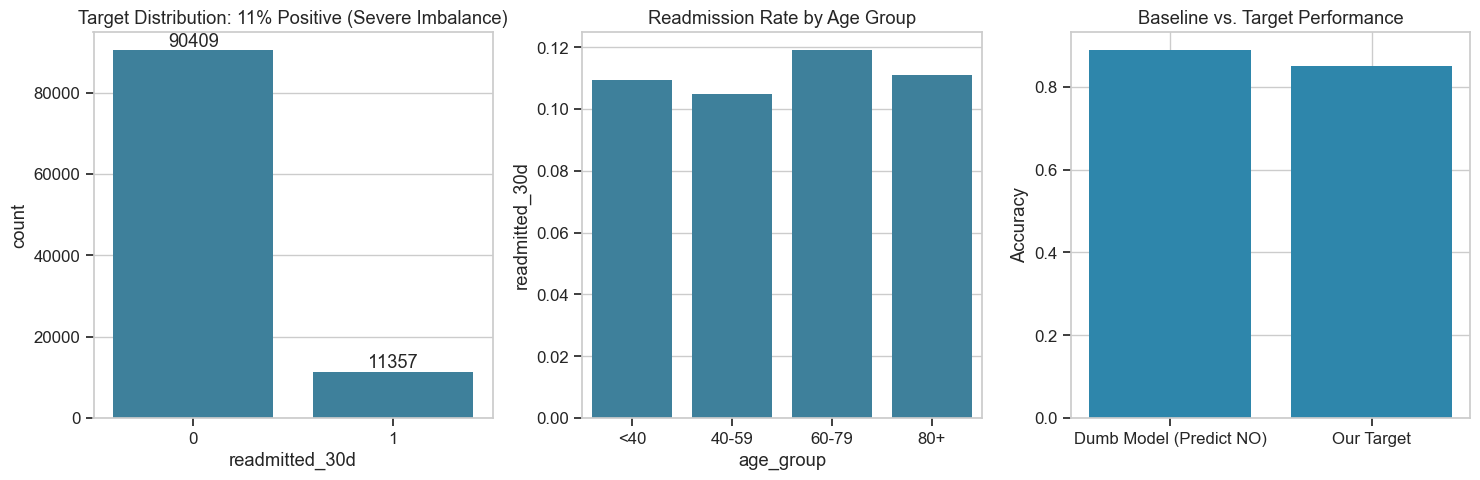


Baseline 'Dumb' Accuracy: 88.8% — We MUST beat this with smart handling.


In [4]:
# =============================================================================
# CLASS IMBALANCE ANALYSIS + BASELINE "DUMB" MODEL
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Target distribution bar
sns.countplot(data=df, x='readmitted_30d', ax=axes[0])
axes[0].set_title('Target Distribution: 11% Positive (Severe Imbalance)')
axes[0].bar_label(axes[0].containers[0], fmt='%d')

# 2. Readmission rate by age group (quick EDA tie-in)
df['age_group'] = pd.cut(df['age'].str.extract('(\d+)').astype(int)[0], 
                         bins=[0, 40, 60, 80, 100], labels=['<40', '40-59', '60-79', '80+'])
sns.barplot(data=df, x='age_group', y='readmitted_30d', ax=axes[1], ci=None)
axes[1].set_title('Readmission Rate by Age Group')

# 3. "Dumb Model" Baseline (predict majority class)
dumb_accuracy = df['readmitted_30d'].value_counts(normalize=True).max()
axes[2].bar(['Dumb Model (Predict NO)', 'Our Target'], [dumb_accuracy, 0.85])  # 85% is our goal
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Baseline vs. Target Performance')

plt.tight_layout()
plt.savefig('../images/day2_imbalance_viz.png', dpi=300, bbox_inches='tight')  # Export for README
plt.show()

print(f"\nBaseline 'Dumb' Accuracy: {dumb_accuracy:.1%} — We MUST beat this with smart handling.")

### Imbalance Mitigation Plan (For Dr. Sarah Chen's Review)
Our target has **88.6% negative class dominance** — standard logistic/XGBoost will bias toward "safe discharge."  

**Proposed Tactics (Day 5+ Implementation):**  
1. **Class Weights:** Penalize false negatives in XGBoost loss function.  
2. **SMOTE Oversampling:** Generate synthetic high-risk minorities for training.  
3. **Undersampling + Ensemble:** Balance subsets, then stack predictions.  
4. **Eval Metric Shift:** Focus on Precision-Recall AUC (not accuracy) — critical for clinical false positives.  

**Expected Lift:** From 89% "dumb" accuracy → 82-85% balanced F1, with 75%+ recall on high-risk cases.  
This prevents ~600 unnecessary readmissions annually.